# Mean Variance Frontier with Short Sales Constraints

This notebook alculates mean variances frontiers for two cases *(1)* when there are no restrictions on the portfolio weights and *(2)* when we impose the restriction that no weights can be negative.

We use the package [OSQP.jl](https://github.com/osqp/OSQP.jl) which solves problems of the type:

$\min 0.5\theta' P \theta + q' \theta$ subject to $l \leq A \theta \leq u$.

As an alternative, consider the [EfficientFrontier.jl](https://github.com/PharosAbad/EfficientFrontier.jl) package.

## Load Packages and Utility Functions

In [1]:
using Printf, LinearAlgebra, SparseArrays, OSQP

include("src/printmat.jl");

In [2]:
using Plots
default(size = (480,320),fmt = :png)

# Inputs to MV Calculations

In [3]:
μ = [11.5, 9.5, 6]/100      #expected returns
Σ = [166  34  58;           #covariance matrix
      34  64   4;
      58   4 100]/100^2
Rf = 0.03

assetNames = ["A","B","C"]
printblue("μ in %:")
printmat(μ*100;rowNames=assetNames,prec=2)

printblue("Σ in bp:")
printmat(Σ*10000;rowNames=assetNames,colNames=assetNames,prec=2)

printblue("Rf in %:")
printlnPs(Rf*100)

μ in %:
A     11.50
B      9.50
C      6.00

Σ in bp:
          A         B         C
A    166.00     34.00     58.00
B     34.00     64.00      4.00
C     58.00      4.00    100.00

Rf in %:
     3.000


# Traditional MV Calculations 

(when there are no constraints) from the chapter on MV analysis.

The file included below contains the function `MVCalc()` from the chapter on MV analysis. It calculates the (MV efficient) portfolio standard deviation for a given required return (`μˣ`), for the case of no restrictions on the portfolio except that the weights sum to one.

### A Remark on the Code
- `[MVCalc(μˣ,μ,Σ)[1] for μˣ in μˣ_range]` is the same as writing a loop over all values in `μˣ_range` and extracting the first output from `MVCalc()` for each iteration.

In [4]:
include("src/MvCalculations.jl");

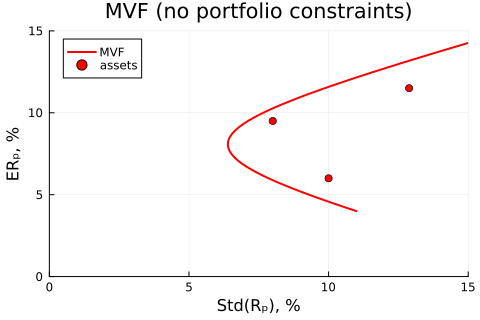

In [5]:
μˣ_range = range(0.04,0.15,length=201)

StdRₚ  = [MVCalc(μˣ,μ,Σ)[1] for μˣ in μˣ_range]         #MV calculations without portfolio restrictions

p1 = plot( StdRₚ*100,μˣ_range*100,
           linecolor = :red,
           linewidth = 2,
           label = "MVF",
           legend = :topleft,
           xlim = (0,15),
           ylim = (0,15),
           title = "MVF (no portfolio constraints)",
           xlabel = "Std(Rₚ), %",
           ylabel = "ERₚ, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="assets")
display(p1)

# MV Frontier when Short Sales are Not Allowed

The code below solves the problem 

$\min \text{Var}(R_p) \: \text{ s.t. } \: \text{E}R_p = \mu^*$,
 
and where we also require $w_i\ge 0$ and $\sum_{i=1}^{n}w_{i}=1$. 

It is straightforward to add other constraints, for instance, that all weights are between 0 and 0.5.

### A Remark on the Code
- The function `MeanVarNoSS(μ,Σ,μˣ)` takes a vector `μˣ_range` as input and loops over those `μˣ_range[i]` values that are feasible (must be between the lowest and highest values in $\mu$).

In [6]:
"""
    MeanVarNoSS(μ,Σ,μˣ_range_range)

Calculate mean variance frontier when short sales are not allowed.


# Input
- `μ::Vector`:        n vector, mean returns
- `Σ::Matrix`:        nxn, covariance matrix of returns, can contain riskfree assets
- `μˣ_range::Vector`: K vector, mean returns to calculate results for

# Output
- `StdRp::Vector`:    K vector, standard deviation of mean-variance portfolio (risky only) with mean `μˣ_range[i]`
- `w_p::Matrix`:      Kxn, portfolio weights of       ""

# Requires
- LinearAlgebra, SparseArrays, OSQP

"""
function MeanVarNoSS(μ,Σ,μˣ_range)   #MV with no short-sales, numerical minimization

    (K,n) = (length(μˣ_range),length(μ))
    vv    = findall( minimum(μ) .<= μˣ_range .<= maximum(μ) )  #solve only if feasible

    P = sparse(2*Σ)                  #P and A must be sparse
    q = zeros(n)
    A = sparse([μ';ones(1,n);I])
    l = [NaN;1;zeros(n)]
    u = [NaN;1;ones(n)]

    prob = OSQP.Model()              #initial set up of problem
    settings = Dict(:verbose => false)
    OSQP.setup!(prob;P=P,q=q,A=A,l=l,u=u,settings...)

    (w_p,StdRp) = (fill(NaN,K,n),fill(NaN,K))
    for i in vv         #loop over (feasible) μˣ_range elements
        (l[1],u[1]) = (μˣ_range[i],μˣ_range[i])
        OSQP.update!(prob;l=l,u=u)   #update problem
        result = OSQP.solve!(prob)
        w = result.info.status == :Solved ? result.x : NaN
        if !any(isnan,w)
            w_p[i,:] = w
            StdRp[i] = sqrt(w'Σ*w)
        end
    end

    return StdRp, w_p

end

MeanVarNoSS

In [7]:
StdRₚ_no_ss = MeanVarNoSS(μ,Σ,μˣ_range)[1];    #MV calculations with no short sales

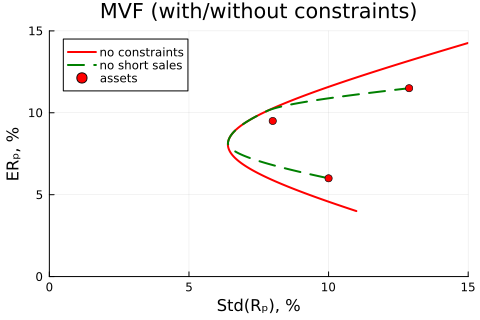

In [8]:
p1 = plot( [StdRₚ StdRₚ_no_ss]*100,μˣ_range*100,
           linecolor = [:red :green],
           linestyle = [:solid :dash],
           linewidth = 2,
           label = ["no constraints" "no short sales"],
           xlim = (0,15),
           ylim = (0,15),
           legend = :topleft,
           title  = "MVF (with/without constraints)",
           xlabel = "Std(Rₚ), %",
           ylabel = "ERₚ, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="assets")
display(p1)